<a href="https://colab.research.google.com/github/fpant1/introtoaiworksheets/blob/main/ws5_nlp_worksheet_with_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Worksheet

In this worksheet we will be implementing the representations that we saw in the lecture, as well as applying these representations to solve a concrete classification problem.

Here is an overview of the sections that we will go through:
1. [Loading the `emotion` dataset](#section1)
2. [Bag-of-words representation](#section2)
3. [TF-IDF representation](#section3)
4. [Word2vec representation](#section4)
5. [FastText representation](#section5)
6. [Transformer representation](#section6)

*Disclaimer*: There is a decent amount of content in this worksheet, so if you are short on time then feel free to skip sections. As long as you load the data by going through the first section, all the other sections are independent of one another. Have fun 😊

We start by installing and importing all the packages we need:

In [ ]:
# Let us ensure that we have the packages we need
!pip install --quiet huggingface_hub datasets wget fasttext==0.9.2 transformers==4.12.3 

     |████████████████████████████████| 182 kB 34.4 MB/s 
     |████████████████████████████████| 451 kB 54.5 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 3.1 MB 15.5 MB/s 
     |████████████████████████████████| 3.3 MB 45.9 MB/s 
     |████████████████████████████████| 880 kB 59.7 MB/s 
     |████████████████████████████████| 212 kB 48.4 MB/s 
     |████████████████████████████████| 115 kB 35.8 MB/s 
     |████████████████████████████████| 127 kB 59.4 MB/s 


In [ ]:
# This will import all the modules that we will need in
# this worksheet.
from datasets import load_dataset, Dataset, load_metric
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Callable, Dict
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from tqdm.auto import tqdm
import wget
import zipfile
import io
import time
import torch
import gc
import traceback
import fasttext.util
from ipywidgets import widgets
from transformers import (AutoConfig, AutoTokenizer, AutoModel, 
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          DataCollatorWithPadding,
                          EarlyStoppingCallback)
from transformers import logging as tf_logging
tf_logging.set_verbosity_error()
tqdm.pandas()
plt.style.use('ggplot')

## Loading the `emotion` Dataset <a class="anchor" id="section1"></a>

As eluded to in the lecture, this worksheet will be working with a text classification dataset.

More specifically, we will be working with the `emotion` dataset, containing Twitter posts with associated emotion labels for each. These labels are `sadness`, `joy`, `love`, `anger`, `fear` and `surprise`.

The following cell will load in the dataset, so we can start working with it!

In [ ]:
def load_emotion_dataset() -> pd.DataFrame:
    '''Loads the emotion dataset from [1].
    
    Returns:
        Triple of Pandas DataFrames:
            The train, validation and test splits of the dataset.
            The dataframes have columns "text" and "label".
            
    References:
        [1] Saravia, Elvis, et al. "Carer: Contextualized affect 
            representations for emotion recognition." Proceedings 
            of the 2018 Conference on Empirical Methods in Natural 
            Language Processing. 2018.
    '''
    # Download the dataset from the HuggingFace Hub
    emotion_datasets = load_dataset('emotion')
    
    # Create list of all the labels in the dataset, in the 
    # correct order
    labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    
    def extract_dataframe(hf_dataset: Dataset) -> pd.DataFrame:
        '''Helper function to convert dataset to DataFrame.
        
        Args:
            hf_dataset (HuggingFace Dataset):
                The dataset to be converted to a DataFrame.
                
        Returns:
            Pandas DataFrame:
                The resulting DataFrame.
        '''
        # Convert to DataFrame
        df = hf_dataset.to_pandas()
        
        # Add more descriptive label column
        df['label_description'] = df.label.map(lambda idx: labels[idx])
        
        # Return the DataFrame
        return df
    
    # Extract the DataFrames
    train = extract_dataframe(emotion_datasets['train'])
    val = extract_dataframe(emotion_datasets['validation'])
    test = extract_dataframe(emotion_datasets['test'])
    
    # Return the three splits
    return train, val, test

train, val, test = load_emotion_dataset()
print(f'Loaded {len(train):,} train samples, {len(val):,} validation samples and {len(test):,} test samples.')
train.head()

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Loaded 16,000 train samples, 2,000 validation samples and 2,000 test samples.


,text,label,label_description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


We see that this dataset contains texts (the `text` column), labels (the `label` column) as well as a description for the given label (the `label_description` column).

To have an idea of how the dataset labels are distributed, we can use the `hist` method to plot a histogram of the `label_description` column. 

*Fill in the missing lines of code in the following function.*

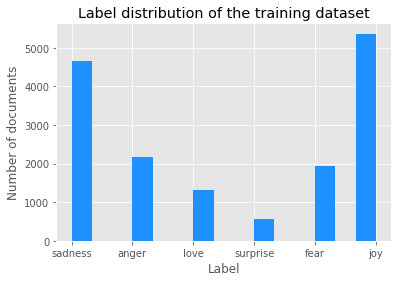

In [ ]:
def plot_label_distribution(df: pd.DataFrame):
    '''Plots a histogram of the labels in the dataset.
    
    Args:
        df (Pandas DataFrame): 
            The input dataframe. Must have a 'label' column.     
    '''

    # TODO: Plot a histogram of the labels by using the `hist` method 
    # of the `label_description` column
    df.label_description.hist(bins='auto', color='dodgerblue')
    
    # These remaining lines just add some labels to the plot
    plt.title('Label distribution of the training dataset')
    plt.xlabel('Label')
    plt.ylabel('Number of documents')
    plt.show()
    
    
plot_label_distribution(train)

We note that the labels are quite unbalanced, making the classification task potentially quite difficult.

Next, we want to have an idea of how long the texts in the dataset are.

*Fill in the missing lines of code in the following function.*

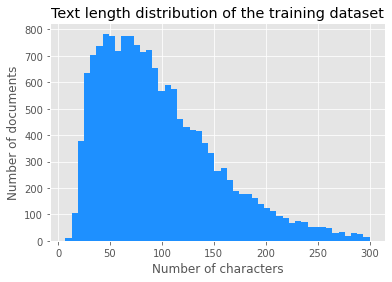

In [ ]:
def plot_text_length_distribution(df: pd.DataFrame):
    '''Plots a histogram of the lengths of the texts in the dataset.
    
    Args:
        df (Pandas DataFrame): 
            The input dataframe. Must have a 'text' column.     
    '''
    # TODO: Add new column to the dataframe, with the number of 
    # characters in each document.
    df['doc_length'] = df.text.map(len)

    # TODO: Plot a histogram of the document lengths using the `hist` method
    df.doc_length.hist(bins='auto', color='dodgerblue')

    # These remaining lines just add some labels to the plot
    plt.title('Text length distribution of the training dataset')
    plt.xlabel('Number of characters')
    plt.ylabel('Number of documents')
    plt.show()
    
    
plot_text_length_distribution(train)

We can see from the plot that the texts are relatively short (at most 300 characters), which makes sense as the texts are tweets! In any case, it's always good to sanity check your data in this way.

Before we start modelling, let us see a few examples of each of our labels, to have an idea of what the dataset looks like.

In [ ]:
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for label in labels:
    print(label.upper())
    display(train.query('label_description == @label').text.head().tolist())
    print()

SADNESS


['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'i feel like i have to make the suffering i m seeing mean something',
 'i feel low energy i m just thirsty']


JOY


['i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious',
 'i do not feel reassured anxiety is on each side',
 'i have the feeling she was amused and delighted']


LOVE


['i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i feel romantic too',
 'i can t let go of that sad feeling that i want to be accepted here in this first home of mine',
 'i ate i could feel a gentle tingle throughout almost as if i was feeling the healing taking place at a cellular level',
 'i suppose my own truth needs to be shared i havent been feeling very faithful lately ive dwelled more in doubt and uncertainty than i have in faith']


ANGER


['im grabbing a minute to post i feel greedy wrong',
 'i am feeling grouchy',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel irritated and rejected without anyone doing anything or saying anything',
 'i already feel like i fucked up though because i dont usually eat at all in the morning']


FEAR


['i feel as confused about life as a teenager or as jaded as a year old man',
 'i now feel compromised and skeptical of the value of every unit of work i put in',
 'i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for',
 'i remember feeling acutely distressed for a few days',
 'i was stymied a little bit as i wrote feeling unsure that i might go somewhere with the story unintended']


SURPRISE


['ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies',
 'i keep feeling pleasantly surprised at his supportiveness and also his ease in new situations',
 'i am now nearly finished the week detox and i feel amazing',
 'i too feel as if i am a stranger in a strange land and i am raising my son in a place that is not his father s ancestral home']

## Bag-of-words Representation <a class="anchor" id="section2"></a>

We start with an implementation of the bag-of-words representation for our data.

We will do this both from scratch as well as use tools from the `sklearn` library, and ensure that we get the same results.

Let's start with building the representation from scratch. As we saw in the lecture, we first need to build a vocabulary.

*Fill in the missing lines of code in the following function.*

In [ ]:
def build_vocabulary(corpus: List[str]) -> List[str]:
    '''Constructs the vocabulary from a corpus.
    
    Args:
        list of str:
            The corpus, being a list of documents.
            
    Returns:
        list of str:
            A list containing all unique words in the corpus.
    '''
    # We simplify things here and remove all non-characters from the documents.
    corpus = [re.sub('^[ a-zA-Z]', '', doc) for doc in corpus]
    
    # TODO: We next split every document into words by spaces, and collect these 
    #       in a list. Use the `split` method of `doc` to split up the document 
    #       into a list of words, and collect all the words in a list called `all_words`
    all_words = [word for doc in corpus for word in doc.split()]
    
    # We then get all the unique words by converting the list to a `set` and back 
    # again to a `list`. Make sure that you have defined `all_words` above, otherwise
    # this code will throw an error!
    unique_words = list(set(all_words))
    
    # Return the vocabulary
    return unique_words


vocabulary = build_vocabulary(train.text.tolist())
len(vocabulary)

15242

Great, we now have a vocabulary. Our next step is using the vocabulary to create embeddings for each word.

Recall from the lecture that this is simply a **one-hot vector**, with zeroes everywhere except at the position at which the word appears in the vocabulary.

*Fill in the missing lines of code in the following function.*

In [ ]:
def one_hot_encode(word: str) -> np.ndarray:
    '''One-hot encode a word according to our vocabulary.
    
    Args:
        word (str):
            The word to be encoded. It needs to be present 
            within our vocabulary!
            
    Returns:
        NumPy array:
            The resulting one-hot encoding.
    '''
    # TODO: Create a new NumPy array of all zeroes, of the same 
    #       length as our vocabulary. You can use the `np.zeros`
    #       function here.
    embedding = np.zeros(len(vocabulary))
    
    # TODO: Get the position at which the word appears in the 
    #       vocabulary, using the `index` method of `vocabulary`
    vocab_position = vocabulary.index(word)
    
    # TODO: To make it a one-hot vector, we need to ensure that
    #       the `embedding` vector has a 1 at `vocab_position`.
    embedding[vocab_position] = 1
    
    # Return the final one-hot encoded vector
    return embedding
    
    
one_hot_embedding = one_hot_encode('happy')
assert one_hot_embedding.sum() == 1
one_hot_embedding

array([0., 0., 0., ..., 0., 0., 0.])

Great! We are well underway to have our very own bag-of-words embedder.

Note that we assumed that the word that we want to encode belongs to our dataset - we can see what happens if we try to encode a word *outside* the vocabulary:

In [ ]:
try:
    one_hot_encode('Thisisnotaword')
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-9-31ca6193c039>", line 2, in <module>
    one_hot_encode('Thisisnotaword')
  File "<ipython-input-8-0ca6e2f04f50>", line 20, in one_hot_encode
    vocab_position = vocabulary.index(word)
ValueError: 'Thisisnotaword' is not in list


As suspected, we simply get an error stating that the word does not occur in the vocabulary.

To fix this we will implement the simple hack that was mentioned in the lecture. Namely, we attach a new number at the end of our embeddings, which is 1 if the word does not appear in the vocabulary.

In [ ]:
def improved_one_hot_encode(word: str) -> np.ndarray:
    '''One-hot encode a word.
    
    This can also deal with words not in the vocabulary.
    
    Args:
        word (str):
            The word to be encoded.
            
    Returns:
        NumPy array:
            The resulting one-hot encoding.
    '''
    # This tries to embed the word using the one_hot_encode
    # function that we defined above
    try:
        # We embed using our previous function, and add a zero
        # at the end, signifying that the word *is* in our
        # vocabulary
        embedding = np.concatenate((one_hot_encode(word), [0]))
        
    # If the word was *not* in the vocabulary then a ValueError
    # is raised, as we saw above. This "catches" that error and
    # runs the code below instead of the code above
    except ValueError:
        
        # TODO: Create a NumPy array which is of the size of our
        #       vocabulary + 1, with all zeros and a 1 at the end
        embedding = np.zeros(len(vocabulary) + 1)
        embedding[len(vocabulary)] = 1
        
    # Return the embedding, whether it came from the "try block"
    # or the "except block"
    return embedding

embedding = improved_one_hot_encode('Thisisnotaword')
assert embedding.sum() == 1
embedding

array([0., 0., 0., ..., 0., 0., 1.])

It works! Our next step is to create a bag-of-words representations for a whole document, rather than only a word. As stated in the lecture, we do this by:
1. Splitting up the document into words.
2. One-hot encoding all the individual words.
3. Adding up all the one-hot encodings.

Let's get to it!

*Fill in the missing lines of code in the following function.*

In [ ]:
def bag_of_words_embed(doc: str) -> np.ndarray:
    '''Embed a document using the bag-of-words representation.
    
    Args:
        doc (str):
            The document we want to embed.
            
    Returns:
        NumPy array:
            The resulting bag-of-words embedding.
    '''
    # We simplify things here and remove all non-characters from the document,
    # just like we did when we created the vocabulary
    doc = re.sub('^[ a-zA-Z]', '', doc)
    
    # TODO: Split up the document into a list of words
    words = doc.split()
    
    # TODO: Embed all the words, resulting in a list of NumPy arrays
    embeddings = [improved_one_hot_encode(word) for word in words]
    
    # Sum up all the one-hot encoded vectors in `embeddings`
    bag_of_words_embedding = np.sum(embeddings, axis=0)

    # Return the embedding
    return bag_of_words_embedding


embedding = bag_of_words_embed('This is a test')
assert embedding.sum() == 4
embedding

array([0., 0., 0., ..., 0., 0., 0.])

Hooray! We can now embed all the documents in the dataset. This will take a couple of minutes, hang tight.

In [ ]:
# Embeds the texts in the dataset
bag_of_words_embeddings_train = np.stack(train.text.progress_apply(bag_of_words_embed))
bag_of_words_embeddings_val = np.stack(val.text.progress_apply(bag_of_words_embed))
bag_of_words_embeddings_train.shape

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

(16000, 15243)

With all the documents embedded, we can now try training a classifier to predict the emotion label.

Here we will just use a simple logistic regression model, but feel free to replace this by whichever classification model you prefer!

In [ ]:
# Define the model
model = LogisticRegression(max_iter=1_000)

# Train the model
model.fit(bag_of_words_embeddings_train, train.label)

# Evaluate the model on the validation set.
# Note that the metric used by the `score` method varies from model to
# model. For the logistic regression model this metric is accuracy.
val_acc = model.score(bag_of_words_embeddings_val, val.label)
print(f'The model achieved a {100 * val_acc:.2f}% accuracy '
      f'on the validation set.')

The model achieved a 37.10% accuracy on the validation set.


Almost 90% accuracy with six labels, not too shabby at all!

Note however that we previously saw that the labels are quite imbalanced, in which case accuracy is not really a good metric to use. Imagine the extreme case where 99% of the labels were "angry". If our model just *always* predicted "angry" then the accuracy would be 99%, but we still would not say that this model is *good*.

A better score is the **balanced accuracy**, which treats every label as equally important (and it coincides with accuracy if the labels are balanced).

You can read more about this metric [in the sklearn user manual](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).

In [ ]:
predictions = model.predict(bag_of_words_embeddings_val)
val_balanced_acc = balanced_accuracy_score(val.label, predictions)
print(f'The model achieved a {100 * val_balanced_acc:.2f}% balanced '
      f'accuracy on the validation set.')

Even when we balance the score to give equal importance to all labels, we still achieve 84% accuracy, that's pretty good!

Let's see if we can do better with more sophisticated text representations.

In [ ]:
# Delete the bag-of-words embeddings again, to save some memory
del bag_of_words_embeddings_train, bag_of_words_embeddings_val, model
gc.collect()

## TF-IDF Representation <a class="anchor" id="section3"></a>

We will now try to embed the documents using the TF-IDF representation and see if we can improve upon our previous classification score.

Rather than implementing this from scratch, we will be employing the `TfidfVectorizer` class from the `sklearn` library. The following function will be using that class to compute our vocabulary and all the document frequencies.

*Fill in the missing lines of code in the following function.*

In [ ]:
def fit_tfidf(corpus: List[str], **tfidf_params) -> TfidfVectorizer:
    '''Fit a TF-IDF model on a corpus.
    
    This computes the vocabulary and stores all the
    document frequencies in the class.
    
    Args:
        corpus (list of str):
            The corpus on which the TF-IDF model will
            be fitted.
        **tfidf_params:
            Extra keyword parameters to include in the TF-IDF model.
            
    Returns:
        TfidfVectorizer:
            The fitted TF-IDF model.
    '''

    # Initialise the class computing the TF-IDF embeddings
    tfidf = TfidfVectorizer(**tfidf_params)

    # TODO: Use the `fit` method of `tfidf` on the corpus, which
    #       computes the vocabulary and all the document 
    #       frequencies from the training dataset, and stores 
    #       them.
    tfidf.fit(corpus)
    
    # Return the fitted TF-IDF model
    return tfidf


tfidf = fit_tfidf(train.text)
tfidf

That only took a split second! Next, just like with the bag-of-words representation, we want to embed our corpus and train a logistic regression model on the embeddings. We will be using our new fitted `TfidfVectorizer` to compute the embeddings this time.

*Fill in the missing lines of code in the following function.*

In [ ]:
def tfidf_train_model(tfidf_model: TfidfVectorizer,
                      train_dataset: pd.DataFrame,
                      val_dataset: pd.DataFrame) -> LogisticRegression:
    '''Trains a logistic regression model on a TF-IDF embedded corpus.
    
    Args:
        tfidf_model (TfidfVectorizer):
            The fitted TF-IDF model.
        train_dataset (Pandas DataFrame):
            The dataset on which to train the logistic regression 
            model. Must have a 'text' and 'label' column.
        val_dataset (Pandas DataFrame):
            The dataset on which to evaluate the logistic regression 
            model. Must have a 'text' and 'label' column.
            
    Returns:
        LogisticRegression:
            The trained model.
    '''
    # TODO: Embed the dataset using the TF-IDF representation, using
    #       the `transform` method of `tfidf_model`
    tfidf_embeddings_train = tfidf_model.transform(train_dataset.text)
    tfidf_embeddings_val = tfidf_model.transform(val_dataset.text)
    
    # Define the model
    model = LogisticRegression(max_iter=1_000)
    
    # Train the model
    model.fit(tfidf_embeddings_train, train_dataset.label)
    
    # Evaluate the model on the validation set.
    predictions = model.predict(tfidf_embeddings_val)
    val_balanced_acc = balanced_accuracy_score(val_dataset.label, predictions)
    print(f'The model achieved a {100 * val_balanced_acc:.2f}% '
          f'balanced accuracy on the validation set.')
    
    # Return the trained model
    return model

model = tfidf_train_model(tfidf_model=tfidf, train_dataset=train, val_dataset=val)

Oh no! We see that our performance has actually **dropped** by using the TF-IDF embeddings.

In some cases the bag-of-words approach are simply better than the TF-IDF representation, but in our current case we can actually improve the performance quite substantially by tweaking the hyperparameters of our TF-IDF embedding.

Firstly, by default the `TfidfVectorizer` normalises the resulting embeddings, which in our scenario severely reduces performance:

In [ ]:
improved_tfidf = fit_tfidf(train.text, norm=None)
improved_model = tfidf_train_model(tfidf_model=improved_tfidf, 
                                   train_dataset=train, 
                                   val_dataset=val)

Getting close to the bag-of-words approach now!

We can improve it even more, by ignoring words that occurs in more than 10% of the documents (so, effectively removing common words like "the" and "an":

In [ ]:
even_better_tfidf = fit_tfidf(train.text, norm=None, max_df=0.1)
even_better_model = tfidf_train_model(tfidf_model=even_better_tfidf, 
                                      train_dataset=train, 
                                      val_dataset=val)

This took us a percentage point above the bag-of-words approach! You can keep on tweaking the parameters in our `fit_tfidf` function to see if you can improve it even further.

You can see all the hyperparameters that you can tune in the [sklearn documentation of TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

## Word2vec Representation <a class="anchor" id="section4"></a>

We next move to the Word2vec representation. To train our own embeddings we will use the `gensim` library.

In [ ]:
def fit_word2vec(corpus: List[str]) -> Word2Vec:
    '''Fit Word2Vec vectors on a corpus.
    
    Args:
        corpus (list of str):
            The corpus to fit the embeddings on.
            
    Returns:
        Word2Vec:
            The object containing the fitted embeddings.
    '''
    # Tokenise the corpus
    corpus = [re.split(r' |(?=[\.\,\-\"\'\!])', doc) for doc in corpus]
    
    # Fit the embeddings
    word2vec = Word2Vec(sentences=corpus, sg=1, workers=-1)

    # Return the object containing the fitted embeddings
    return word2vec


word2vec = fit_word2vec(train.text)
word2vec

With the model trained, we can now extract the individual word embeddings using the `wv` dictionary attribute:

In [ ]:
word2vec.wv['test']

This model has a vocabulary, just like our previous models, and will throw an error if faced with a word it has not seen before:

In [ ]:
try:
    word2vec.wv['Test']
except:
    traceback.print_exc()

To deal with these out-of-vocabulary words, we will use the same hack we did with the bag-of-words approach: we will simply associate a new vector to all the terms that the model has not previously seen. For simplicity, we will just associate the zero vector to these terms.

*Fill in the missing lines of code in the following function.*

In [ ]:
def word2vec_embed_term(term: str) -> np.ndarray:
    '''Embeds a term using the fitted Word2vec model.
    
    Args:
        term (str):
            The term to be embedded.
            
    Returns:
        NumPy array:
            The embedding of the term.
    '''
    # We do a `try-except` here to deal with out-of-vocabulary terms,
    # just like we did with the bag-of-words model
    try:
        
        # TODO: Use the `wv` attribute of `word2vec` to get
        #       the embedding of the term
        embedding = word2vec.wv[term]
        
    # If the word is not in our vocabulary, then we just
    # embed it as the zero vector
    except KeyError:
        embedding = np.zeros(100)
    
    # Return the embedding
    return embedding


word2vec_embed_term('house')

We next go from embedding terms to embedding documents. Recall that we have to make a decision here, depending on how we want to aggregate the individual term embeddings.

*Fill in the missing lines of code in the following function.*

In [ ]:
def word2vec_embed_doc(doc: str, 
                       aggregation_fn: Callable = np.mean) -> np.ndarray:
    '''Embeds a document using the fitted Word2vec model.
    
    Args:
        doc (str):
            The document to be embedded.
        aggregation_fn (callable, optional):
            The function used to aggregate the term embeddings
            in the document. Must be a NumPy function. Defaults to 
            `numpy.mean`, meaning that the average of the term 
            embeddings is returned.
            
    Returns:
        NumPy array:
            The embedding of the document.
    '''
    # Split up the document into a list of terms
    terms = re.split(r' |(?=[\.\,\-\"\'\!])', doc)
    
    # TODO: Embed each term using the fitted `word2vec` model.
    #       The result should be a list of embeddings, one for
    #       each term.
    embeddings = [word2vec_embed_term(term) for term in terms]
    
    # Aggregate the embeddings according to `aggregation_fn`
    embedding = aggregation_fn(embeddings, axis=0)
    
    # Return the aggregated embedding
    return embedding


word2vec_embed_doc('this is a test')

Okay, we can finally test the classification performance of the Word2vec embeddings!

*Fill in the missing lines of code in the following function.*

In [ ]:
def word2vec_train_model(train_dataset: pd.DataFrame,
                         val_dataset: pd.DataFrame) -> LogisticRegression:
    '''Trains a logistic regression model on a Word2vec embedded corpus.
    
    Args:
        train_dataset (Pandas DataFrame):
            The dataset on which to train the logistic regression 
            model. Must have a 'text' and 'label' column.
        val_dataset (Pandas DataFrame):
            The dataset on which to evaluate the logistic regression 
            model. Must have a 'text' and 'label' column.
            
    Returns:
        LogisticRegression:
            The trained model.
    '''    
    # TODO: Embed the dataset with the Word2vec representation, using
    #       our `word2vec_embed` function. The result should be a list
    #       of embeddings, one for each document.
    word2vec_embeddings_train = [word2vec_embed_doc(doc) 
                                 for doc in train_dataset.text]
    word2vec_embeddings_val = [word2vec_embed_doc(doc) 
                               for doc in val_dataset.text]
    
    # Convert the lists of embeddings to one big matrix
    word2vec_embeddings_train = np.stack(word2vec_embeddings_train)
    word2vec_embeddings_val = np.stack(word2vec_embeddings_val)
    
    # Define the classification model
    model = LogisticRegression(max_iter=1_000)
    
    # Train the model
    model.fit(word2vec_embeddings_train, train_dataset.label)
    
    # Evaluate the model on the validation set.
    predictions = model.predict(word2vec_embeddings_val)
    val_balanced_acc = balanced_accuracy_score(val_dataset.label, predictions)
    print(f'The model achieved a {100 * val_balanced_acc:.2f}% '
          f'balanced accuracy on the validation set.')
    
    # Return the trained model
    return model


model = word2vec_train_model(train_dataset=train, val_dataset=val)

That was... disappointing. What happened here?

It turns out that these more advanced embeddings simply require **a lot** more data. Simply training new embeddings on our small dataset is nowhere near good enough. A lesson learnt in how a TF-IDF vector can be superior when we do not have pretrained embeddings at our disposal!

In the next section, we will download pretrained FastText vectors, so that we can see the difference in performance.

In [ ]:
# Delete the Word2vec embeddings again, to save some memory
del word2vec, model
gc.collect()

## FastText Representation <a class="anchor" id="section5"></a>

As we saw in the lecture, the FastText embeddings are so similar to the Word2vec embeddings that training them again will result in roughly the same poor performance as we saw with the Word2vec embeddings.

So instead, let us take our first step into the world of transfer learning, and download pretrained FastText embeddings. These take up quite a lot of disk space, and will take some time to download.

In [ ]:
%%time

def load_pretrained_fasttext_model() -> fasttext.FastText._FastText:
    '''Downloads pretrained FastText model and loads it.
    
    Returns:
        FastText model:
            The pretrained FastText model.
    '''
    # Download the model if it has not been downloaded already
    fasttext.util.download_model('en', if_exists='ignore')
    
    # Load the model
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ft_model = fasttext.load_model('cc.en.300.bin')
    
    # Return the model
    return ft_model
    
ft_model = load_pretrained_fasttext_model()

With the FastText model loaded, we can now get word vectors by using the `get_word_vector` method:

In [ ]:
ft_model.get_word_vector('Test')

As mentioned in the lecture, this FastText model can deal with words not in its vocabulary:

In [ ]:
ft_model.get_word_vector('Thisisnotaword')

As we also mentioned in the lecture, FastText _distinguishes_ sentences from words. Technically speaking, we could use the `get_word_vector` on a document to get a vector for the entire document. What that would do is simply create n-grams for all of the document, embed those individually, and add them up.

The model usually performs better by _first_ splitting the document into words, compute n-gram embeddings _within every word_, the sum of which would then constitute the individual word embeddings. To arrive at the sentence embeddings we then take the mean of all the word embeddings.

This difference between these two approaches is reflected in the `fasttext` API by the `get_word_vector` and `get_sentence_vector` methods, the latter of which is the "proper" one to use when embedding documents.

Here is an example of such an embedding:

In [ ]:
ft_model.get_sentence_vector('This is a document')

Okay, all that remains to do now is to extract the FastText embeddings from all of our documents and train a logistic regression classifier. Let's get to it!

*Fill in the missing lines of code in the following function.*

In [ ]:
def fasttext_train_model(train_dataset: pd.DataFrame,
                         val_dataset: pd.DataFrame) -> LogisticRegression:
    '''Trains a logistic regression model on a FastText embedded corpus.
    
    Args:
        train_dataset (Pandas DataFrame):
            The dataset on which to train the logistic regression 
            model. Must have a 'text' and 'label' column.
        val_dataset (Pandas DataFrame):
            The dataset on which to evaluate the logistic regression 
            model. Must have a 'text' and 'label' column.
            
    Returns:
        LogisticRegression:
            The trained model.
    '''    
    # TODO: Embed the dataset with the FastText representation, using
    #       the `get_sentence_vector` method of our `ft_model`. The result 
    #       should be a list of embeddings, one for each document.
    fasttext_embeddings_train = [ft_model.get_sentence_vector(doc) 
                                 for doc in train_dataset.text]
    fasttext_embeddings_val = [ft_model.get_sentence_vector(doc) 
                               for doc in val_dataset.text]
    
    # Convert the lists of embeddings to one big matrix
    fasttext_embeddings_train = np.stack(fasttext_embeddings_train)
    fasttext_embeddings_val = np.stack(fasttext_embeddings_val)
    
    # Define the classification model
    model = LogisticRegression(max_iter=1_000)
    
    # Train the model
    model.fit(fasttext_embeddings_train, train_dataset.label)
    
    # Evaluate the model on the validation set.
    predictions = model.predict(fasttext_embeddings_val)
    val_balanced_acc = balanced_accuracy_score(val_dataset.label, predictions)
    print(f'The model achieved a {100 * val_balanced_acc:.2f}% '
          f'balanced accuracy on the validation set.')
    
    # Return the trained model
    return model


model = fasttext_train_model(train_dataset=train, val_dataset=val)

The performance definitely improved upon our "hometrained" Word2vec vectors, but it is still falling way short of the simpler TF-IDF vectors.

A reason why this might be the case is that predicting emotion might be too simple a task, as simply looking for keywords appearing in the text (like "angry") suffices in most cases to classify the documents accurately.

In [ ]:
# Delete the FastText model again, to save some memory
del ft_model, model
gc.collect()

## Transformer Representation <a class="anchor" id="section6"></a>

Our final step into the world of representations is the transformer embedding.

We will be utilising transfer learning here, as we really should do in 99.9% of all cases. To achieve this, we will be using the `transformers` library, which makes using state-of-the-art transformer embeddings really simple.

In this section we will be using the `roberta-base` model, but this can be replaced by almost all of the models available on [the HuggingFace Hub](https://hf.co). Go check it out and replace `roberta-base` in the code below with your favorite model!

In [ ]:
def load_pretrained_transformer(model_id: str = 'roberta-base') -> tuple:
    '''Load pretrained transformer with its tokeniser.

    Args:
        model_id (str, optional):
            The transformer model to load. Defaults to 'roberta-base'.

    Returns:
        tuple:
            A pair of the pretrained transformer and its tokeniser.
    '''
    # Create list of all the labels in the dataset
    labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    
    # Load model
    config = dict(num_labels=len(labels),
                  id2label={id:lbl for id, lbl in enumerate(labels)},
                  label2id={lbl:id for id, lbl in enumerate(labels)})
    config = AutoConfig.from_pretrained(model_id, **config)
    tokeniser = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                               config=config)
    
    return model, tokeniser


tf_model, tokeniser = load_pretrained_transformer()

With the pretrained model and tokeniser loaded, we next need to tokenise our corpus. Recall that to **tokenise** a document simply means that we split it up in smaller parts. This could be words, but these transformer tokenisers tend to split up some words into *subwords*. Let's see a quick example of this:

In [ ]:
doc = 'This tokeniser is really quite extravagant.'
[tokeniser.decode(tok) for tok in tokeniser(doc).input_ids]

We see a few differences from merely splitting up by words:
1. Punctuation gets its own token.
2. The documents are separated by the special tokens `<s>` and `</s>`.
3. Some words are split into multiple tokens. Here we se that "tokeniser" was split into the tokens `token` and `iser`.

Let us split our dataset into tokens now.

*Fill in the missing lines of code in the following function.*

In [ ]:
def tokenise_corpus(dataset: pd.DataFrame, tokeniser) -> Dataset: 
    '''Tokenises a dataset according to a pretrained tokeniser.
    
    Args:
        dataset (Pandas DataFrame):
            The dataset to tokenise. Must have 'text' and 'label' columns.
            
    Returns:
        HuggingFace Dataset:
            The tokenised dataset.
    '''
    # Build HuggingFace datasets
    dataset = Dataset.from_dict(dict(doc=dataset.text, labels=dataset.label))
    
    # TODO: Create a function which takes a dictionary as input and which calls 
    #       our `tokeniser` on the `doc` entry of the dictionary. When calling
    #       `tokeniser` you want to set `truncation=True` and `padding=True`, as
    #       otherwise you will encounter an error!
    def tokenise(examples: dict) -> dict:
        doc = examples['doc']
        return tokeniser(doc, truncation=True, padding=True)

    # Tokenise dataset
    tokenised = dataset.map(tokenise, batched=True)

    # Return tokenised dataset
    return tokenised

tokenised_train = tokenise_corpus(train, tokeniser=tokeniser)
tokenised_val = tokenise_corpus(val, tokeniser=tokeniser)

With the pretrained model loaded and our datasets all tokenised, we are now ready to finetune our very own transformer model. The following function will set up the training arguments and finetune our model.

If you have not already done so, I would advise you to enable GPU acceleration when finetuning, as otherwise it might take a long time. You can do this in the Colab notebook by clicking `Runtime -> Change runtime type -> Hardware accelerator = GPU`.

In [ ]:
def finetune_transformer(tf_model, 
                         tokenised_train: Dataset, 
                         tokenised_val: Dataset):
    '''Train transformer model.

    Args:
        tf_model (HuggingFace Transformer):
            Pretrained transformer.
        tokenised_train (Dataset):
            Tokenised train dataset.
        tokenised_val (Dataset):
            Tokenised validation dataset.

    Returns:
      HuggingFace Transformer:
          Finetuned transformer.
    '''
    # Set up training arguments
    tf_logging.set_verbosity_warning()
    training_args = TrainingArguments(
        output_dir='.',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        learning_rate=2e-5,
        warmup_steps=len(train) // 8,
        save_total_limit=1,
        load_best_model_at_end=True
    )

    def compute_metrics(predictions_and_labels: tuple) -> dict:
        '''Helper function to compute the balanced accuracy'''
        predictions, labels = predictions_and_labels
        predictions = predictions.argmax(axis=-1)
        results = balanced_accuracy_score(labels, predictions)
        return dict(balanced_accuracy=results)

    # Initialise the Trainer object
    trainer = Trainer(model=tf_model,
                      args=training_args,
                      train_dataset=tokenised_train,
                      eval_dataset=tokenised_val,
                      tokenizer=tokeniser,
                      compute_metrics=compute_metrics)
    
    # Train
    trainer.train()
    
    return tf_model
    

tf_model = finetune_transformer(tf_model=tf_model,
                                tokenised_train=tokenised_train,
                                tokenised_val=tokenised_val)

We see that our transformer model succesfully beat the TF-IDF representation, hoorah! But note the amount of hoops we had to go through to arrive at a finetuned transformer model. Our application really has to be worth it to make us go through all of that!

Note that we only trained our transformer model for 3 epochs (meaning 3 passes of the training dataset), so you might be able to achieve an even better performance by training it for longer. You can even look into [early stopping](https://huggingface.co/transformers/main_classes/callback.html?highlight=earlystopping#transformers.EarlyStoppingCallback), which automatically stops training the model when performance stops improving. Try it out!

Finally, as the big finale, you can play around with your newly finetuned model, by running the cell below:

In [ ]:
# Disable HuggingFace logging
tf_logging.set_verbosity_error()

# Define the widget elements
label = widgets.Label('Write some text:')
input_box = widgets.Text()
button = widgets.Button(description='Predict emotion')
output_label = widgets.Label()

# Display the widget elements
for elt in [label, input_box, button, output_label]:
    display(elt)

def predict_emotion(_):
    '''Predicts emotion of text'''

    # Set Transformer to evaluation mode
    tf_model.eval()

    # Get the document
    doc = input_box.value

    # Show "in progress" text
    output_label.value = "Computing prediction..."

    # Create list of all the labels in the dataset
    labels = ['sadness', 'joy', 'love', 'anger', 'fear',
              'surprise', 'trust', 'disgust', 'anticipation']

    # Load the tokeniser
    tokeniser = AutoTokenizer.from_pretrained('roberta-base')
    
    # Get emotion prediction
    tokens = tokeniser(doc,
                      return_tensors='pt',
                      truncation=True,
                      padding=True)
    prediction = tf_model.cpu()(**tokens).logits.argmax().int()
    
    # Convert the prediction to the corresponding label
    predicted_label = labels[prediction]
    
    # Show the predicted label
    output_label.value = predicted_label

# Connect the button with the prediction function
button.on_click(predict_emotion)

## Conclusion

In this worksheet, we explored several ways of embedding text, and used those embeddings to classify the emotion of a given text.

We saw that the bag-of-words embeddings were performing really well, despite their simplicity, and that we could only beat them with the TF-IDF vectors with some hyperparameter tweaking. We tried the Word2vec vectors next, and saw that training them from scratch on our small corpus resulted in terrible performance. To remedy that, we downloaded pretrained FastText vectors and used those instead, which increased the performance, but still falling short of the TF-IDF performance. Lastly, we used pretrained transformer embeddings for the task, which successfully improved upon the TF-IDF vectors.